In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes for those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.

We will first identify all patients with prostate cancer (using the primary site code C619). Then we will split the above patient population into two groups as follows: The treatment group, defined as the patients receiving any form of radiation; and the control group, defined as the patients who did not receive any form of radiation. Operationally, these groups are defined by looking at the column RADIATN, which has values:

| Code	| Description |
|:---------:|:-------------:|
|0|	None; diagnosed at autopsy |
|1|	Beam radiation |
|2|	Radioacative implants |
|3|	Radioisotopes |
|4|	Combination of 1 with 2 or 3 |
|5|	Radiation, NOS - method or source not specified |
|6|	Other radiation (1973-1987 cases only) |
|7|	Patient or patient's guardian refused radiation therapy |
|8|	Radiation recommened, unknown if administered |
|9|	Unknown if radiation administered |

So that a value of 0 defines the control group, and teh values (1,2,3,4,5,6) define the treatment group. We will then perform matching between the resulting treatment and control groups.

In [4]:
import seerhelp
malegenfiles = seerhelp.get_malegenfiles()
malegenfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\MALEGEN.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\MALEGEN.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\MALEGEN.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\MALEGEN.txt']

In [5]:
import seerhelp
malegenfiles = seerhelp.get_malegenfiles()


dfmalegen0 = seerhelp.make_clean_dataframe(malegenfiles[0])
dfmalegen1 = seerhelp.make_clean_dataframe(malegenfiles[1])
dfmalegen2 = seerhelp.make_clean_dataframe(malegenfiles[2])
dfmalegen3 = seerhelp.make_clean_dataframe(malegenfiles[3])

dfmalegen = pd.concat([dfmalegen0, dfmalegen1, dfmalegen2,
                     dfmalegen3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfmalegen.shape)

del dfmalegen0
del dfmalegen1
del dfmalegen2
del dfmalegen3

(1214943, 141)


In [6]:
dfmalegen.PRIMSITE.value_counts()

Prostate gland                                  1152617
Testis, NOS                                       32028
Descended testis                                  16107
Penis, NOS                                         6139
Glans penis                                        2526
Scrotum, NOS                                       1756
Prepuce                                            1346
Undescended testis                                  883
Body of penis                                       512
Spermatic cord                                      500
Overlapping lesion of penis                         267
Overlapping lesion of male genital organs            91
Male genital organs, NOS                             83
Epididymis                                           59
Other specified parts of male genital organs         29
Name: PRIMSITE, dtype: int64

In [8]:
dfprostateorig = dfmalegen[dfmalegen.PRIMSITE.str.contains('prostate',case=False)]
dfprostateorig.PRIMSITE.value_counts()

Prostate gland    1152617
Name: PRIMSITE, dtype: int64

In [10]:
mask = (dfprostateorig['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
(dfprostateorig['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfprostateorig['CSTUMSIZ'] != "989 millimeters or larger") & \
(dfprostateorig['CSTUMSIZ'] != "Not applicable") & \
(dfprostateorig['AGE_DX'] != "Unknown age") & \
(dfprostateorig['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
(dfprostateorig['YEAR_DX'] >= 2004) & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfprostateorig['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfprostateorig['CSTUMSIZ'] != "Not applicable") & \
(dfprostateorig['YR_BRTH'] != 'Unknown year of birth') & \
(dfprostateorig['CSTUMSIZ'] != 'Not applicable') & \
(dfprostateorig['CSTUMSIZ'] != 996) & \
(dfprostateorig['CSTUMSIZ'] != 997) & \
(dfprostateorig['CSTUMSIZ'] != 998) & \
(dfprostateorig['REC_NO'] == 1) 

dfprostate = dfprostateorig[mask]



In [11]:
non_rad = dfprostate.RADIATN.str.contains('None',case=False,na=False)
refused_rad = dfprostate.RADIATN.str.contains('refused',case=False,na=False)
unknown_rad = dfprostate.RADIATN.str.contains('Unknown',case=False,na=False)

In [12]:
dfprostatecontrol = dfprostate[non_rad | refused_rad].copy()
dfprostatetreatment = dfprostate[~(non_rad) & ~(refused_rad) & ~(unknown_rad)].copy()

In [13]:
print(dfprostatecontrol.shape, dfprostatetreatment.shape)


(51588, 141) (7261, 141)


## <font color='steelblue'>So we are going to match patients in the treatment group with their nearest neighbors in the control group</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do some preprocessing of the data. The first step is to "one-hot-encode" the categorical features.

In [14]:
dfprostatecontrol.set_index('PUBCSNUM', inplace=True)
dfprostatetreatment.set_index('PUBCSNUM', inplace=True)

controlindices = dfprostatecontrol.index
treatmentindices = dfprostatetreatment.index

catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


dfpop = pd.concat([dfprostatecontrol, dfprostatetreatment],verify_integrity=True)

## <font color='steelblue'>Before matching, let's look at the Kaplan-Meier curves</font>

In [15]:
resgoodcontrol = pd.concat([pd.get_dummies(dfprostatecontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfprostatetreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

resgoodcontrol['YR_BRTH'] = dfprostatecontrol['YR_BRTH']
resgoodcontrol['AGE_DX'] = dfprostatecontrol['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodcontrol['YEAR_DX'] = dfprostatecontrol['YEAR_DX']
resgoodcontrol['CSTUMSIZ'] = dfprostatecontrol['CSTUMSIZ']
resgoodcontrol['lat'] = dfprostatecontrol['lat']
resgoodcontrol['lng'] = dfprostatecontrol['lng']
resgoodcontrol['srv_time_mon'] = dfprostatecontrol['srv_time_mon']


resgoodtreatment['YR_BRTH'] = dfprostatetreatment['YR_BRTH']
resgoodtreatment['AGE_DX'] = dfprostatetreatment['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodtreatment['YEAR_DX'] = dfprostatetreatment['YEAR_DX']
resgoodtreatment['CSTUMSIZ'] = dfprostatetreatment['CSTUMSIZ']
resgoodtreatment['lat'] = dfprostatetreatment['lat']
resgoodtreatment['lng'] = dfprostatetreatment['lng']
resgoodtreatment['srv_time_mon'] = dfprostatetreatment['srv_time_mon']


resgoodpop['YR_BRTH'] = dfpop['YR_BRTH']
resgoodpop['AGE_DX'] = dfpop['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodpop['YEAR_DX'] = dfpop['YEAR_DX']
resgoodpop['CSTUMSIZ'] = dfpop['CSTUMSIZ']
resgoodpop['lat'] = dfpop['lat']
resgoodpop['lng'] = dfpop['lng']
resgoodpop['srv_time_mon'] = dfpop['srv_time_mon']

## <font color='steelblue'>After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

Below is how it looks **before** matching patients in the control and trreatment groups together in pairs. 

In [16]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All left-sided breast');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group)')
#ax = kmfpop.plot()
#ax = kmfcontrol.plot()
#kmftreatment.plot(ax=ax)
#plt.title("Left-sided breast cancer patients Kaplan-Meier Curve (95% CI) \n Pre-Matching");

<lifelines.KaplanMeierFitter: fitted with 7261 observations, 6424 censored>

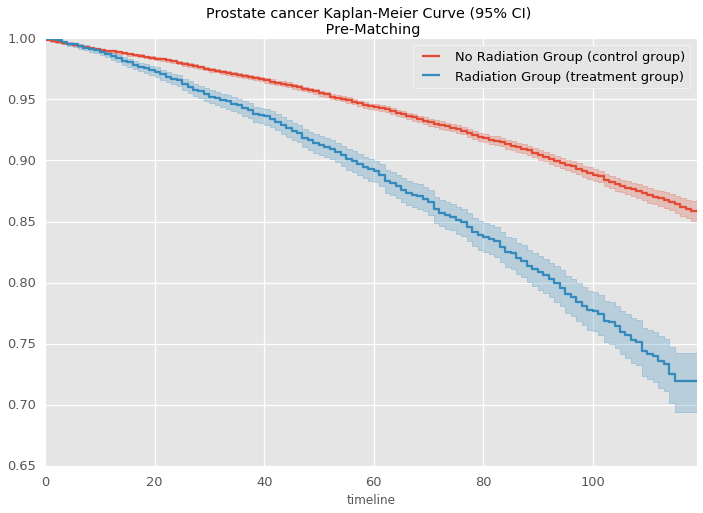

In [17]:
ax = kmfcontrol.plot()
kmftreatment.plot(ax=ax)
plt.title("Prostate cancer Kaplan-Meier Curve (95% CI) \n Pre-Matching");

Different story from the breast caase.

## Radiation therapy for prostate cancer

### When is radiation therapy used?

Radiation may be used:

* As the first treatment for cancer that is still just in the prostate gland and is low grade. Cure rates for men with these types of cancers are about the same as those for men treated with radical prostatectomy.
* As part of the first treatment (along with hormone therapy) for cancers that have grown outside the prostate gland and into nearby tissues.
* If the cancer is not removed comletely or comes back (recurs) in the area of the prostate after surgery.
* If the cancer is advanced, to help keep the cancer under control for as long as possible and to help precent or relieve symptoms.

## <font color='steelblue'>Clearly, there is a difference between these survival curves</font>

But one can argue that we are not really comparing apples to apples when we calculate these two survival curves. To answer this obection, we need to perform patient matching, so that we are really comparing apples to apples and that any marked difference in the survival curves can be confidently attributed to the division between treatment and control groups.

It looks like radiation is only used when surgery is not an option (for more advanced disease stages). Breaking up the radiation grouop into proton therapy patients and others will reveal the the relative benefits.

In [19]:
resgoodpop['YR_BRTH'] = resgoodpop['YR_BRTH'].astype('int')
resgoodpop['AGE_DX'] = resgoodpop['AGE_DX'].astype('int')
resgoodpop['CSTUMSIZ'] = resgoodpop['CSTUMSIZ'].astype('float')
resgoodpop['lat'] = resgoodpop['lat'].astype('float')
resgoodpop['lng'] = resgoodpop['lng'].astype('float')
resgoodpop['srv_time_mon'] = resgoodpop['srv_time_mon'].astype('float')

newcolumns = list(resgoodpop.columns)


newcolumns.remove('srv_time_mon')
newcolumns.remove('STAT_REC_Alive')
newcolumns.remove('STAT_REC_Dead')
newcolumns.remove('SEX_Male')

resgreatpop = resgoodpop[newcolumns].copy()

In [20]:
resgreatpop['PUBCSNUM'] = resgreatpop.index
leaguefilter = (resgreatpop['PUBCSNUM'].loc[treatmentindices])
resgreatpop['League'] = resgreatpop['PUBCSNUM'].isin(treatmentindices).astype('int')
del resgreatpop['PUBCSNUM']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

This brute force method of finding similar patients characterized by points in a high-dimensional space is possible for this data set as well as for Big Data sized data sets thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between pateints/records. For example, **AGE_DX** is on the order of 60 or so, while **YR_BRTH** is around 1960. Without standardization, **YR_BRTH** would contribute much more to the distance between patients than **AGE_DX**. The result of standardization (or Z-score normalization) is that features will be resclaed so that they will have the properties of a standard normal distribution with

$\mu = 0$ and $\sigma = 1$.

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean; standard deviation scores (also called z-scores) are then calculated as follows:

$
z_{i} = \frac{x_{i} - \mu}{\sigma}
$

In [22]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[-0.24122155  0.5856113  -0.0786728  ..., -0.0626709   0.94197805
   1.68454188]
 [-0.24122155  0.5856113  -0.0786728  ..., -0.31030732  0.94313771
   1.70841121]
 [-0.24122155  0.5856113  -0.0786728  ..., -0.09804753  0.83596563
   1.67977397]
 ..., 
 [-0.24122155  0.5856113  -0.0786728  ...,  0.29109541 -1.3709357
   0.67052731]
 [-0.24122155  0.5856113  -0.0786728  ...,  0.04345899 -0.96518634
   0.71092587]
 [-0.24122155  0.5856113  -0.0786728  ..., -0.34568395 -1.29076913
   0.75849744]]


In [23]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)


## <font color='steelblue'>Here is a video explaining the construction of a KDTree</font>

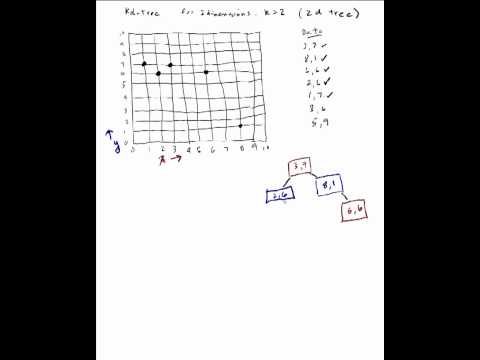

In [24]:
from IPython.display import YouTubeVideo
YouTubeVideo('LdaL-l2S76c')

In [39]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

## <font color='steelblue'>Finding the distances to all of the 4 nearest neighbors only took a few minutes.</font>

In [40]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [41]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

dist1filter = (dftreeleague['distance_1'] <= .3)
dist2filter = (dftreeleague['distance_2'] <= .3)
dist3filter = (dftreeleague['distance_3'] <= .3)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
PUBCSNUM,,,
11751069,92038751,0.274232,0
11753577,90987070,0.187965,0
11835061,11835299,0.141507,0
11835280,93280064,0.202783,0
11835287,93278990,0.288508,0
11842664,11859927,0.226059,0
11858316,11859394,0.212138,0
11861009,93329294,0.074912,0
11861416,93280114,0.175138,0


In [42]:
onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodtreatmentteams = list(dd.keys())

goodcontrolteams = list(dd.values())
matches = list(set([item for sublist in goodcontrolteams for item in sublist]))

controlindices = matches
treatmentindices = goodtreatmentteams
print(len(treatmentindices))
print(len(controlindices))

1197
1493


## <font color='steelblue'>Need to do a one-to-one matching (where each member of the treatment group is matched to one and only one member of the control group, and vice-versa)</font>

In [43]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_t_c = {}

for key, value in d_one_to_one.items():
    if value not in d_t_c.values():
        d_t_c[key] = value
        
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())     

In [44]:
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())

print(len(controlindices), len(treatmentindices))

1157 1157


So we have 1157 treament patients matched very closely (distance less than .3 in the high-dimensional space) to 1157 control patients. This is a good-sized group of matched pairs and will allow us to solid statistical inferences.

## <font color='steelblue'>Now here is the Kaplan-Meier plot for the post-matching treatment and control groups</font>

In [45]:
from lifelines import KaplanMeierFitter

#kmfpop = KaplanMeierFitter()
kmfcontrolpost = KaplanMeierFitter()
kmftreatmentpost = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

#kmfpop.fit(Tpop, event_observed=Epop,label='All Nasopharynx');
kmfcontrolpost.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group; post-matching)')
kmftreatmentpost.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group; post-matching)')
#ax = kmfpop.plot()
###ax = kmfcontrol.plot()
###kmftreatment.plot(ax=ax)
###plt.title("Nasopharynx Kaplan-Meier Curve (95% CI) \n Post-Matching");

<lifelines.KaplanMeierFitter: fitted with 1157 observations, 1054 censored>

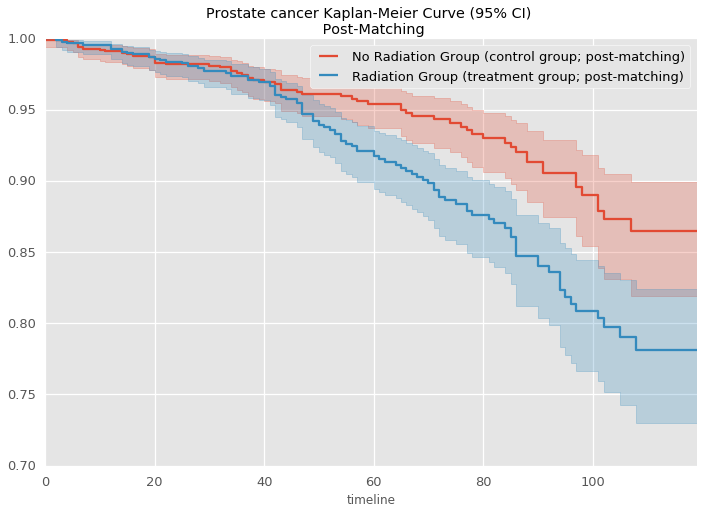

In [46]:
ax = kmfcontrolpost.plot()
kmftreatmentpost.plot(ax=ax)
#kmfcontrol.plot(ax=ax)
#kmftreatment.plot(ax=ax)
plt.title("Prostate cancer Kaplan-Meier Curve (95% CI) \n Post-Matching");


## <font color='steelblue'>We can perform a rigorous test to see if the two survival curves above truly have different "death generation processes."</font>

Looks the prognosis is identical up until just about 40 months.

In [47]:
from lifelines.statistics import logrank_test
results = logrank_test(Ttreatment, Tcontrol, Etreatment, Econtrol)
results.print_summary()

Results
   test: logrank
   null distribution: chi squared
   t 0: -1
   alpha: 0.95
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00103 |             10.771 |      Reject Null    |        True       


## <font color='steelblue'>Because of the matching, the observed differences in the Kaplan-Meier estimates of the survival curves for the control and treatment groups clearly show that there is a statistically significant effect and real benefit to opting for surgery over radiation for prostate cancer.</font>

### <font color='steelblue'>Now let's perfrom some paired t-tests to see if there is any demonstrable difference for some characteristics of interest</font>

You may suspect that some of the observed differences above are due to differences in the age distributions of the traetment and control groups (but our matching procedure should have taken care of and accounted for this possibility; let's see if a t-test based on **AGE_DX** can show that this is **not** the case).

In [48]:
control_age_dx = resgoodpop['AGE_DX'].loc[controlindices]
treatment_age_dx = resgoodpop['AGE_DX'].loc[treatmentindices]
dfage_comp = pd.DataFrame({'control_id': control_age_dx.index,
                          'control_age_dx': control_age_dx.values,
                          'treatment_id': treatment_age_dx.index,
                          'treatment_age_dx':treatment_age_dx.values })
dfage_comp['c_minus_t_age'] = dfage_comp.control_age_dx - dfage_comp.treatment_age_dx

## <font color='steelblue'>Two-sample T-test<font>

A two-sample t-test investigates whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of both groups are the same.

In [49]:
import scipy.stats as stats
stats.ttest_ind(a=dfage_comp.control_age_dx.as_matrix(), 
               b=dfage_comp.treatment_age_dx.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=-0.13301080624550191, pvalue=0.89419640988881011)

The test yields a p-value of 0.89, which means that there is a 89% chance we'd see sample data this far apart if the two groups actually have idential **AGE_DX** distributions. We cannot reject the null hypothesis; our matching worked and we can guarantee that the differing survival curves for the groups are not influenced by **AGE_DX**.

## <font color='steelblue'>Paired T-Test</font>

The basic two sample t-test is designed for testing differences between independent groups. In some cases, you might be interested in testing differences between samples of the same group at different points in time. In observational studies like those using the SEER data, the matched pairs in the control and treatment groups are considered for the purposes of paired t-tests to represent the same entity. Let's see now if there is any significant difference in **AGE_DX** between the treatment and control groups using a paired t-test.

In [50]:
stats.ttest_rel(a = dfage_comp.control_age_dx.as_matrix(),
                b = dfage_comp.treatment_age_dx.as_matrix())

Ttest_relResult(statistic=-1.4440524709246068, pvalue=0.14899517411852545)

## <font color='steelblue'>The paired T-Test also indicates that we actually do not have enough evidence to reject the null hypothesis</font>

In [51]:
apost = dftreeleague['AGE_DX'][treatmentindices]
bpost = dftreeleague['AGE_DX'][controlindices]

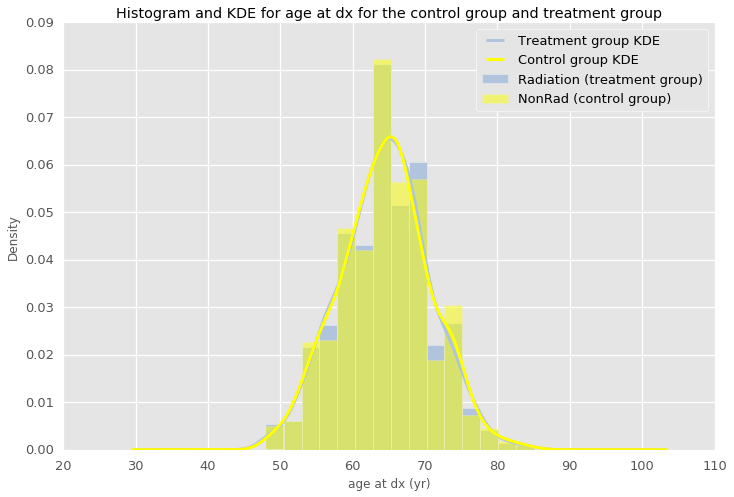

In [52]:
ax = bpost.hist(bins=15,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=15,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for age at dx for the control group and treatment group')
plt.xlabel('age at dx (yr)')
plt.legend();

In [53]:
dfage_comp[['control_age_dx','treatment_age_dx']].describe()

,control_age_dx,treatment_age_dx
count,1157.000000,1157.000000
mean,64.446845,64.481417
std,6.234183,6.268975
min,48.000000,48.000000
25%,60.000000,60.000000
50%,65.000000,65.000000
75%,69.000000,68.000000
max,85.000000,85.000000


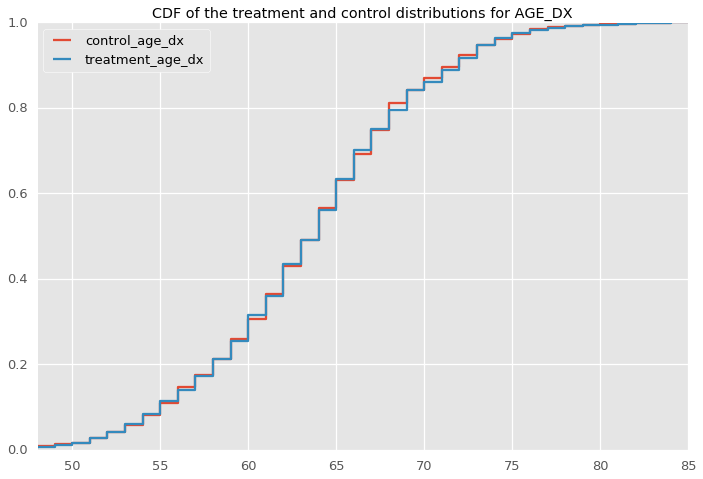

In [54]:
agedxtreatmentcdf = dfage_comp.treatment_age_dx.value_counts(normalize=True).sort_index().cumsum()
agedxcontrolcdf = dfage_comp.control_age_dx.value_counts(normalize=True).sort_index().cumsum()

dfagedx = pd.DataFrame(({'treatment_age_dx': agedxtreatmentcdf,
                        'control_age_dx': agedxcontrolcdf}))

dfagedx = dfagedx.fillna(method='ffill')

dfagedx.plot(drawstyle='steps',
            title='CDF of the treatment and control distributions for AGE_DX');

## <font color='steelblue'>Can also quantify the similarity of two distributions using the Kolmogorov-Smirnov test</font>

the k-s test returns a D statistic and a p-value corresponding to the D statistic. The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution. https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

The p-value returned by the k-s test has the same interpretation as other p-values. You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level. The closer the p-value is to 1, the better our matching.

In [55]:
agedxresults = stats.ks_2samp(dfage_comp.treatment_age_dx.as_matrix(),
                             dfage_comp.control_age_dx.as_matrix())
print(agedxresults)

Ks_2sampResult(statistic=0.016421780466724267, pvalue=0.9974812743103324)


## <font color='steelblue'>Box-and-whiskers plots are especially good for visualizing and comparing two distributions</font>

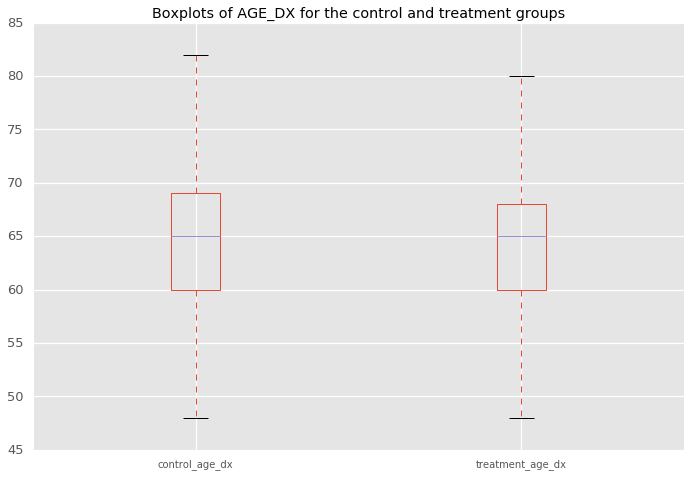

In [56]:
dfage_comp.boxplot(['control_age_dx','treatment_age_dx'],
                  return_type='axes');

plt.title('Boxplots of AGE_DX for the control and treatment groups');

## <font color='steelblue'>Let's check to make sure the distributions for some of the other features used in the matching are close to identical between the treatment and control groups</font>

Look at these numerical columns:

* **YR_BRTH**
* **YEAR_DX**
* **CSTUMSIZ**
* **lat**

In [57]:
control_yr_brth = resgoodpop['YR_BRTH'].loc[controlindices]
treatment_yr_brth = resgoodpop['YR_BRTH'].loc[treatmentindices]
dfyob_comp = pd.DataFrame({'control_id': control_yr_brth.index,
                          'control_yr_brth': control_yr_brth.values,
                          'treatment_id': treatment_yr_brth.index,
                          'treatment_yr_brth':treatment_yr_brth.values })
dfyob_comp['c_minus_t_yob'] = dfyob_comp.control_yr_brth - dfyob_comp.treatment_yr_brth


import scipy.stats as stats
stats.ttest_ind(a=dfyob_comp.control_yr_brth.as_matrix(), 
               b=dfyob_comp.treatment_yr_brth.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=0.056900298303086939, pvalue=0.95462953363360636)

In [58]:
stats.ttest_rel(a = dfyob_comp.control_yr_brth.as_matrix(),
                b = dfyob_comp.treatment_yr_brth.as_matrix())

Ttest_relResult(statistic=0.68146341415775902, pvalue=0.49571480219682318)

In [59]:
apost = dftreeleague['YR_BRTH'][treatmentindices]
bpost = dftreeleague['YR_BRTH'][controlindices]

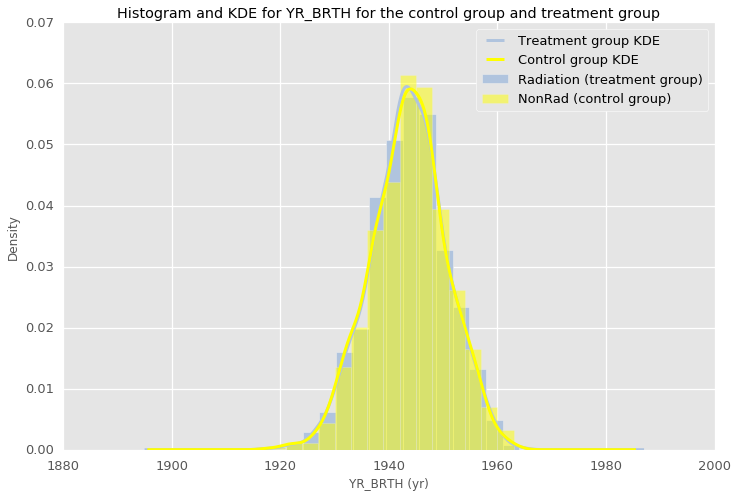

In [60]:
ax = bpost.hist(bins=15,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=15,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for YR_BRTH for the control group and treatment group')
plt.xlabel('YR_BRTH (yr)')
plt.legend();

In [61]:
yobtreatmentcdf = dfyob_comp.treatment_yr_brth.value_counts(normalize=True).sort_index().cumsum()
yobcontrolcdf = dfyob_comp.control_yr_brth.value_counts(normalize=True).sort_index().cumsum()

dfyob = pd.DataFrame(({'treatment_yr_brth': yobtreatmentcdf,
                        'control_yr_brth': yobcontrolcdf}))

dfyob = dfyob.fillna(method='ffill')

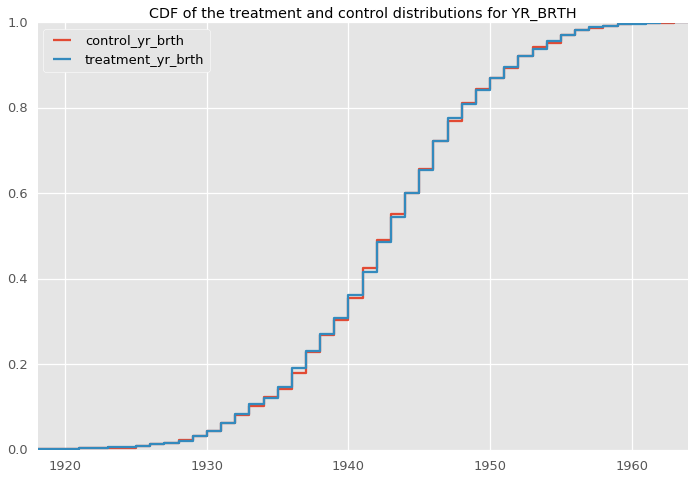

In [62]:
dfyob.plot(drawstyle='steps',
            title='CDF of the treatment and control distributions for YR_BRTH');

In [63]:
yobresults = stats.ks_2samp(dfyob_comp.treatment_yr_brth.as_matrix(),
                             dfyob_comp.control_yr_brth.as_matrix())
print(yobresults)

Ks_2sampResult(statistic=0.011235955056179775, pvalue=0.99999949382697617)


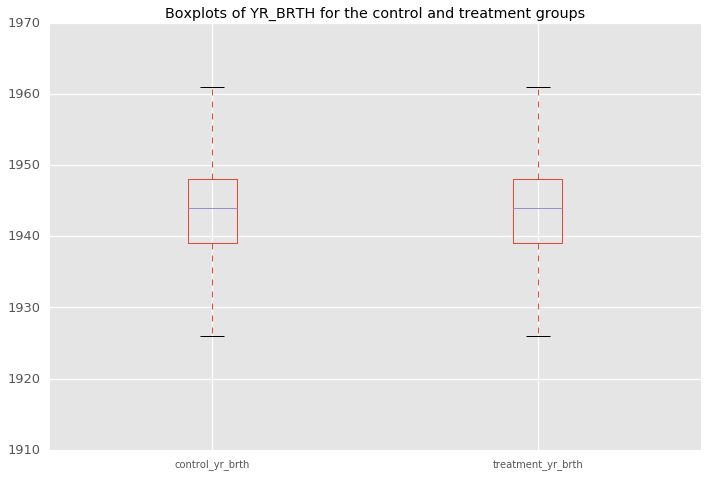

In [64]:
dfyob_comp.boxplot(['control_yr_brth','treatment_yr_brth'],
                  return_type='axes');

plt.title('Boxplots of YR_BRTH for the control and treatment groups');

In [66]:
control_yr_dx = resgoodpop['YEAR_DX'].loc[controlindices]
treatment_yr_dx = resgoodpop['YEAR_DX'].loc[treatmentindices]
dfyrdx_comp = pd.DataFrame({'control_id': control_yr_dx.index,
                          'control_yr_dx': control_yr_dx.values,
                          'treatment_id': treatment_yr_dx.index,
                          'treatment_yr_dx':treatment_yr_dx.values })
dfyrdx_comp['c_minus_t_yrdx'] = dfyrdx_comp.control_yr_dx - dfyrdx_comp.treatment_yr_dx


import scipy.stats as stats
stats.ttest_ind(a=dfyrdx_comp.control_yr_dx.as_matrix(), 
               b=dfyrdx_comp.treatment_yr_dx.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [68]:
apost = dftreeleague['YEAR_DX'][treatmentindices]
bpost = dftreeleague['YEAR_DX'][controlindices]

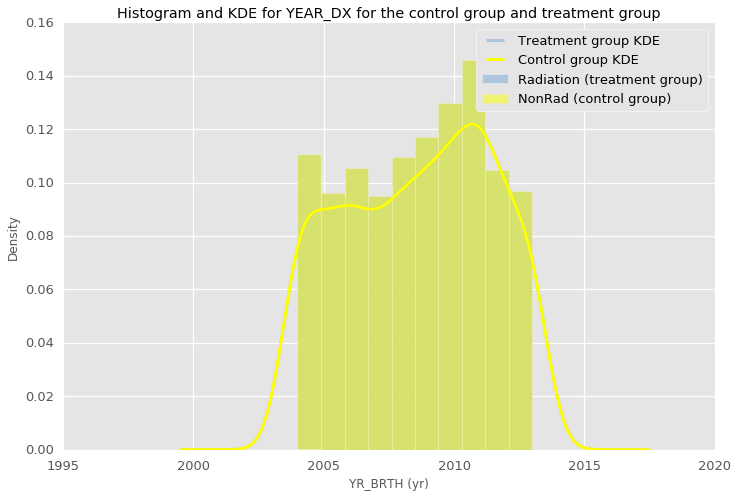

In [75]:
ax = bpost.hist(bins=10,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=10,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for YEAR_DX for the control group and treatment group')
plt.xlabel('YR_BRTH (yr)')
plt.legend();

In [76]:
yrdxtreatmentcdf = dfyrdx_comp.treatment_yr_dx.value_counts(normalize=True).sort_index().cumsum()
yrdxcontrolcdf = dfyrdx_comp.control_yr_dx.value_counts(normalize=True).sort_index().cumsum()

dfyrdx = pd.DataFrame(({'treatment_yr_dx': yrdxtreatmentcdf,
                        'control_yr_dx': yrdxcontrolcdf}))

dfyrdx = dfyrdx.fillna(method='ffill')

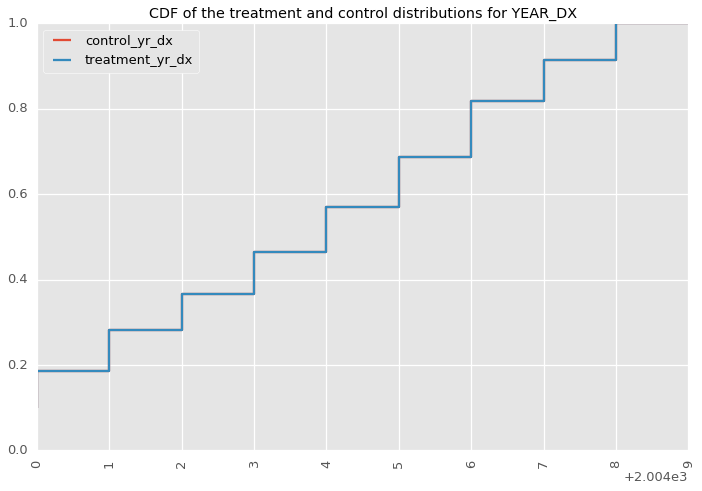

In [77]:
dfyrdx.plot(drawstyle='steps',
            title='CDF of the treatment and control distributions for YEAR_DX',rot=90);

In [78]:
yrdxresults = stats.ks_2samp(dfyrdx_comp.treatment_yr_dx.as_matrix(),
                             dfyrdx_comp.control_yr_dx.as_matrix())
print(yrdxresults)

Ks_2sampResult(statistic=0.0, pvalue=1.0)


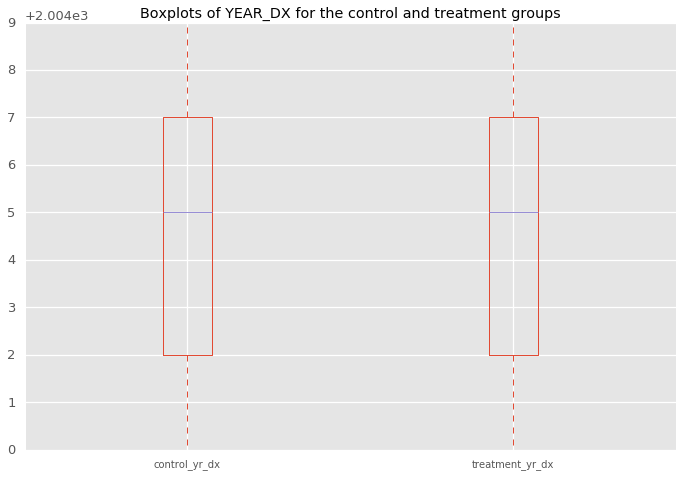

In [79]:
dfyrdx_comp.boxplot(['control_yr_dx','treatment_yr_dx'],
                  return_type='axes');

plt.title('Boxplots of YEAR_DX for the control and treatment groups');

In [80]:
apost = dftreeleague['CSTUMSIZ'][treatmentindices]
bpost = dftreeleague['CSTUMSIZ'][controlindices]



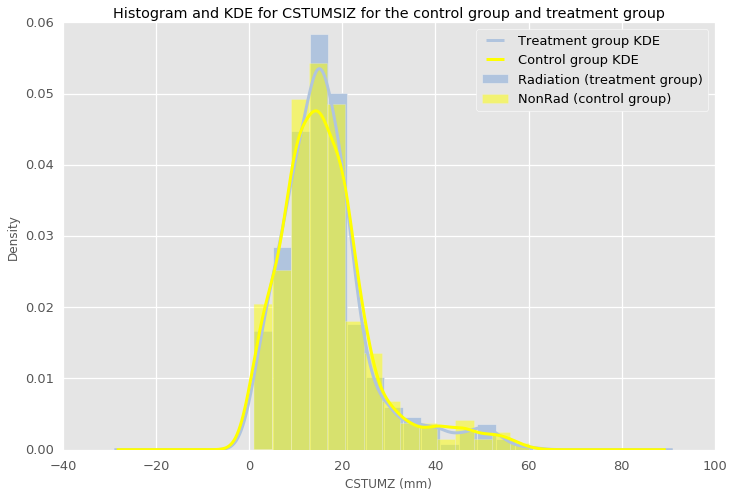

In [81]:
ax = bpost.hist(bins=15,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=15,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for CSTUMSIZ for the control group and treatment group')
plt.xlabel('CSTUMZ (mm)')
plt.legend();

## <font color="steelblue">The histograms and KDE approximations for the CSTUMSIZ distributions also look very similar</font>

The CDF and the Kolmogorov-Smirnov test also confirm that we can not reject the null hypothesis. But we still the stange reporting bias of numbers ending in 5 or 0 as in the breast cancer case. 

In [82]:
treatmenttum = dftreeleague['CSTUMSIZ'][treatmentindices]
controltum = dftreeleague['CSTUMSIZ'][controlindices]

treatmenttumcdf = treatmenttum.value_counts(normalize=True).sort_index().cumsum()
controltumcdf = controltum.value_counts(normalize=True).sort_index().cumsum()

dftum = pd.DataFrame({'treatment_tumsize': treatmenttumcdf,
                     'control_tumsize': controltumcdf})

dftum = dftum.fillna(method='ffill')


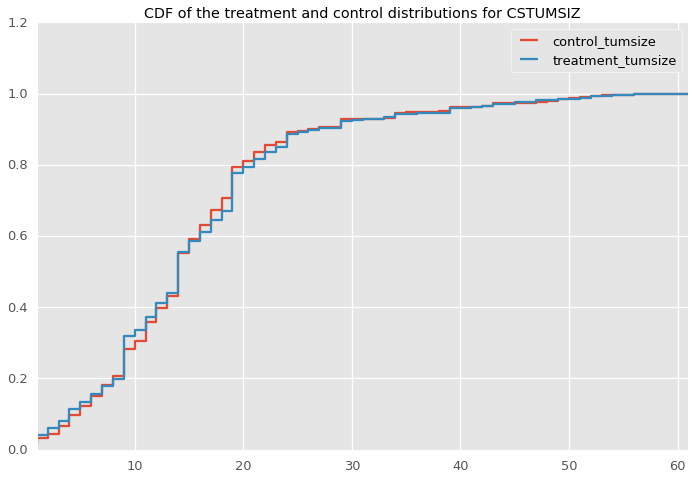

In [83]:
dftum.plot(drawstyle='steps',
          title='CDF of the treatment and control distributions for CSTUMSIZ');


In [84]:
tumresults = stats.ks_2samp(treatmenttum.as_matrix(),
                             controltum.as_matrix())
print(tumresults)

Ks_2sampResult(statistic=0.037165082108902348, pvalue=0.39477003002715955)


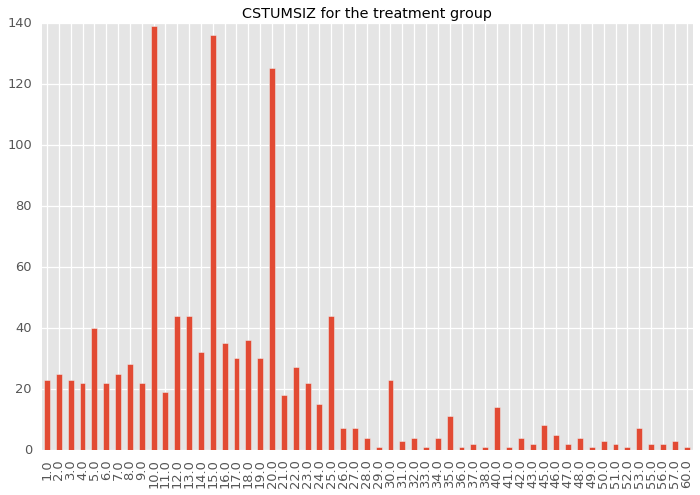

In [85]:
treatmenttum.value_counts().sort_index().plot(kind='bar',
    title='CSTUMSIZ for the treatment group');


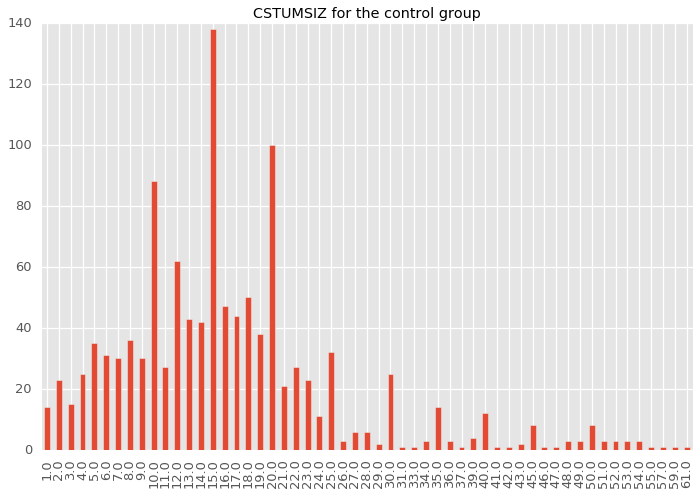

In [86]:
controltum.value_counts().sort_index().plot(kind='bar',
    title='CSTUMSIZ for the control group');

In [87]:
control_cstumsiz = resgoodpop['CSTUMSIZ'].loc[controlindices]
treatment_cstumsiz = resgoodpop['CSTUMSIZ'].loc[treatmentindices]
dfcstumsiz_comp = pd.DataFrame({'control_id': control_cstumsiz.index,
                          'control_cstumsiz': control_cstumsiz.values,
                          'treatment_id': treatment_cstumsiz.index,
                          'treatment_cstumsiz':treatment_cstumsiz.values })
dfcstumsiz_comp['c_minus_t_cstumsiz'] = dfcstumsiz_comp.control_cstumsiz - dfcstumsiz_comp.treatment_cstumsiz

## <font color='steelblue'>And the box plots for CSTUMSIZ visually show the coarse-grained agreement</font>

* The K-S test is very sensitive to granularity. The CSTUMSIZ data suffers from systematic plus the usual random measurement uncertaintly. AGE_DX, YEAR_BRTH, etc. suffer from zero measurement uncertaintly.

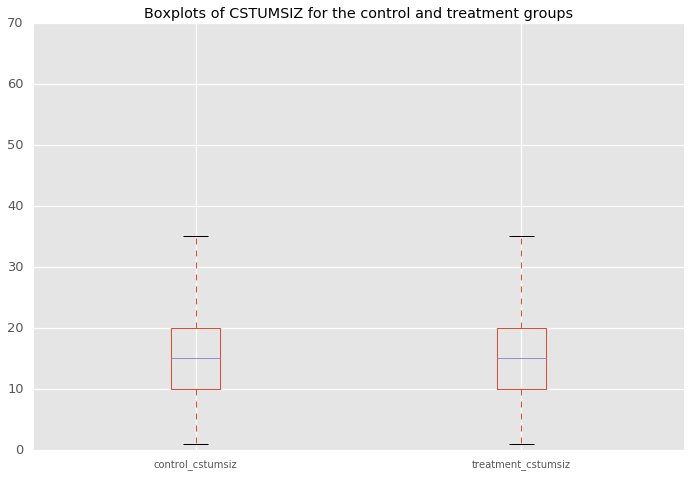

In [88]:
dfcstumsiz_comp.boxplot(['control_cstumsiz','treatment_cstumsiz'],
                  return_type='axes');

plt.title('Boxplots of CSTUMSIZ for the control and treatment groups');

In [89]:
dfcstumsiz_comp[['control_cstumsiz','treatment_cstumsiz']].describe()

,control_cstumsiz,treatment_cstumsiz
count,1157.000000,1157.000000
mean,16.464996,16.512532
std,9.976869,10.277174
min,1.000000,1.000000
25%,10.000000,10.000000
50%,15.000000,15.000000
75%,20.000000,20.000000
max,61.000000,60.000000


In [90]:
control_lat = resgoodpop['lat'].loc[controlindices]
treatment_lat = resgoodpop['lat'].loc[treatmentindices]
dflat_comp = pd.DataFrame({'control_id': control_lat.index,
                          'control_lat': control_lat.values,
                          'treatment_id': treatment_lat.index,
                          'treatment_lat':treatment_lat.values })
dflat_comp['c_minus_t_lat'] = dflat_comp.control_lat - dflat_comp.treatment_lat


import scipy.stats as stats
stats.ttest_ind(a=dflat_comp.control_lat.as_matrix(), 
               b=dflat_comp.treatment_lat.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=0.003157360115036843, pvalue=0.9974810676900141)

In [91]:
stats.ttest_rel(a = dflat_comp.control_lat.as_matrix(),
                b = dflat_comp.treatment_lat.as_matrix())

Ttest_relResult(statistic=0.038028023841744134, pvalue=0.96967190426208438)

In [92]:
apost = dftreeleague['lat'][treatmentindices]
bpost = dftreeleague['lat'][controlindices]

## <font color='steelblue'>The latitude is obtained from the STATE and COUNTY FIPS codes and the google maps API</font>

The SEER registries do not cover the entire United States and are limited to certain regions; hence the funny looking distributions for lat shown next.

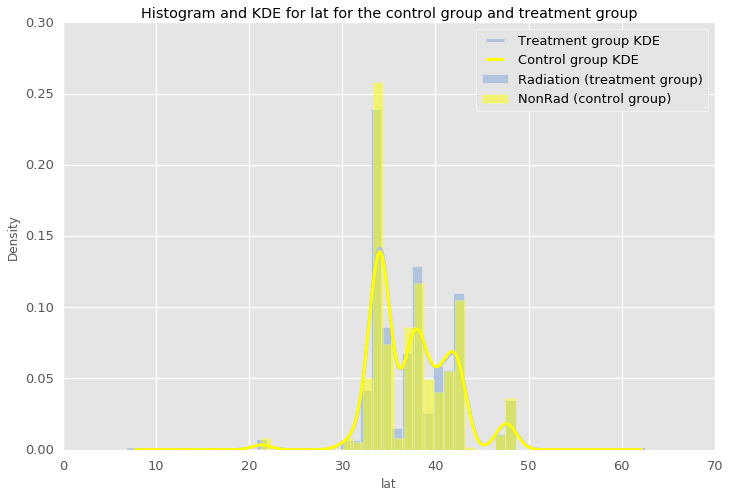

In [93]:
ax = bpost.hist(bins=25,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=25,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for lat for the control group and treatment group')
plt.xlabel('lat')
plt.legend();

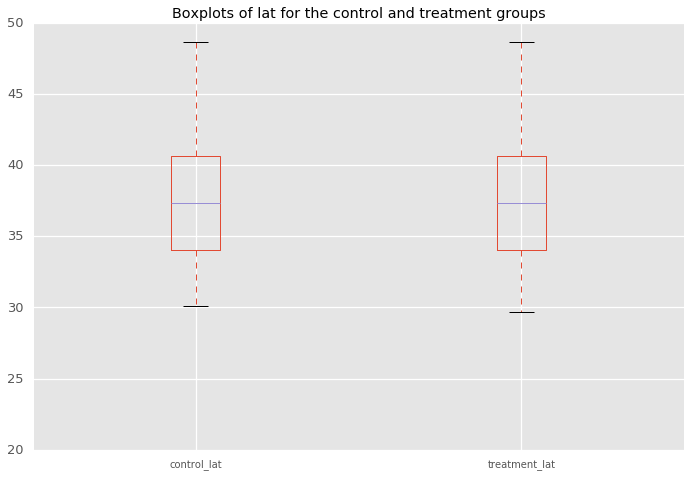

In [94]:
dflat_comp.boxplot(['control_lat','treatment_lat'],
                  return_type='axes');

plt.title('Boxplots of lat for the control and treatment groups');


## <font color='steelblue'>Let's also check how the matching performed on the categorical features</font>

Check the distributions between the treatment and control groups for:

* **GRADE**
* **RACEIV**

and more.

In [99]:
dfprostateorig = dfprostateorig.set_index('PUBCSNUM',drop=False)


In [100]:
dfprostateorig['GRADE'].loc[treatmentindices].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               853
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    302
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  2
Name: GRADE, dtype: int64

In [101]:
dfprostateorig['GRADE'].loc[controlindices].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               853
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    302
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  2
Name: GRADE, dtype: int64